In [125]:
from sqlalchemy import TextClause, Row
import re

import pandas as pd
import sys

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


sys.path.insert(1, r"..\models")
sys.path.insert(2, r"..\etl")

from lstm_model import load_model_weights_from_checkpoint
from connect_db import connect_to_grad_db

In [80]:
model = load_model_weights_from_checkpoint() 

In [81]:
engine = connect_to_grad_db()

In [82]:
with engine.connect() as conn:
    query = TextClause("select content from news_api")
    content = conn.execute(query).fetchall()

In [83]:
content[1]._data[0]

"\n\n\n\n\n\n\n\n\n\nDuangpetch Phromthep speaks at a news conference in Thailand following his rescue from a cave in July 2018. \n\nSoe Zeya Tun/Reuters\n\n\n\n\n\n\n\nLondon\nCNN\n        \xa0—\xa0\n    \n\n\nDuangphet Phromthep, one of the 12 boys rescued from a flooded Thai cave after a weekslong operation that drew global attention in 2018, has died in the UK, British and Thai officials announced Wednesday. \n  \n\n      Phromthep, who was enrolled in a soccer academy in Leicestershire, England, died after being rushed to hospital on Sunday, Leicestershire Police said in a statement to CNN. \n  \n\n      Th northern regional branch of the Thai government’s public relations arm said on Facebook that Phromthep, 17, died due to an accident, without providing more details. \n  \n\n      “The atmosphere at his house in Chiang Rai province was full of sorrow,” PR Thailand’s statement said. \n  \n\n      Zico Foundation, a Thai non-profit organization which had helped Phromthep study in 

In [85]:
def ready_text_for_pred(text):
    processed_text = re.sub(r" +", " ", (re.sub(r"[^a-zA-Z]", " ", text)).lower().strip())
    return processed_text

def preprocess_article_content(content):
    content = content.strip("\n")

    # Remove all special characters except sentence defining punctuation
    cleaned_content = re.sub(r"[^.!?\w]", " ", content)

    # Remove multiple spaces
    cleaned_content = re.sub(r"[ ]+", " ", cleaned_content)

    # Split on sentence punctuation
    split_sentences = re.split(r"[.!?]", cleaned_content)

    cleaned_sentences = [ready_text_for_pred(sentence) for sentence in split_sentences if sentence != ""]
    
    return cleaned_sentences

In [86]:
sentences = preprocess_article_content(content[1]._data[0])

In [135]:
model.predict(["tesla is an obvious scam"])

1/1 [==============================] - 0s 88ms/step


array([[1.0827405]], dtype=float32)

In [87]:
preds = model.predict(sentences)

2/2 [==============================] - 1s 32ms/step


In [88]:
stats = {sentence:pred for sentence, pred in zip(sentences, preds)}

In [89]:
df = pd.DataFrame(
    {
        "sentence":sentences,
        "prediction":preds.flatten()
    }
)

In [105]:
df.iloc[14,1]

1.401653

In [106]:
import datasets
dataset = datasets.load_dataset("sst2")

c:\Users\duggurd\New Folder\graduation_project\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset sst2 downloaded and prepared to C:/Users/duggurd/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 68.50it/s]


In [114]:
test = pd.DataFrame(dataset["train"])

In [116]:
test["pred"] = model.predict(test["sentence"])

2105/2105 [==============================] - 90s 42ms/step


In [118]:
test["pred_binary"] = (test["pred"] > 2)*1

In [119]:
test

,idx,sentence,label,pred,pred_binary
0,0,hide new secretions from the parental units,0,2.618384,1
1,1,"contains no wit , only labored gags",0,0.759405,0
2,2,that loves its characters and communicates som...,1,3.726185,1
3,3,remains utterly satisfied to remain the same t...,0,3.714559,1
4,4,on the worst revenge-of-the-nerds clichés the ...,0,0.690909,0
...,...,...,...,...,...
67344,67344,a delightful comedy,1,3.859110,1
67345,67345,"anguish , anger and frustration",0,3.582586,1
67346,67346,"at achieving the modest , crowd-pleasing goals...",1,2.346077,1
67347,67347,a patient viewer,1,1.113854,0


In [120]:
true = test["label"].value_counts()
preds = test["pred_binary"].value_counts()

In [131]:
test["label"].sum()/test["pred_binary"].sum()

0.8615557492088245

In [122]:
preds

1    43606
0    23743
Name: pred_binary, dtype: int64

In [128]:
import matplotlib.pyplot as plt 

confusion_matrix(test["label"], test["pred_binary"])

array([[18227, 11553],
       [ 5516, 32053]], dtype=int64)

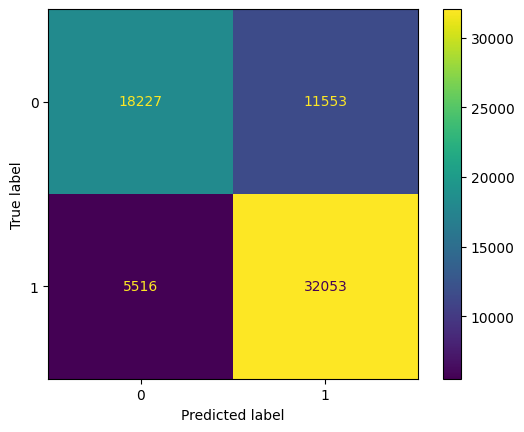

In [130]:
ConfusionMatrixDisplay(confusion_matrix(test["label"], test["pred_binary"])).plot()
plt.show()